# Rapid Assessment - Hansen Global Tree Cover Loss 2001-2021

This script contains estimate the total forest area and deforestation rate. The output from this script will be:
1. Area Estimation (Excel File)
* Forest/Non-Forest Map Area in 2000 and 2022
* Primary Forest Area in 2000 and 2022
* Annual Forest Loss in 2001-2022
2. Raster Map (GeoTiff)
* Forest/Non-Forest Map Area in 2000 and 2022
* Primary Forest Area in 2000 and 2022
* Annual Forest Loss in 2001-2022

## Initialize geemap module

In [3]:
%matplotlib inline
# Earth Engine Packages
import os
import ee
import geemap
import geopandas as gpd
# Directory Packages
import tkinter as tk
from tkinter import Tk, filedialog, simpledialog, messagebox
# Import data frame calculation package
import pandas as pd
from datetime import datetime, date
from datetime import date
#Import data visualization package in python
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
#Geospatial Packages
import rasterio
from rasterio.plot import show
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np
from rasterio.transform import from_origin
import matplotlib as mlp
import geoplot as gplt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

## Data Preparation
Forest is define as land area that has more than certain forest coverage threshold. In this section, input parameter such as forest definition threshold, projection and minimum mapping unit (ha) should be defined
* forest_threshold = minimum forest coverage that is considered as forest
* projection = UTM projection code
* pixels = forest minimum area in a pixel format (2 Ha = 22 pixels, 1 Ha = 11 pixels, 0.5 Ha = 6 pixels)
* loss pixels = minimum mapping area for tree loss (usually same as the minimum forest area)
* roi_directory = specify the directory of the roi using '', eg. 'c:/data/roi/shapefile.shp'
* output_directory = specify the output directory folder using '', eg. 'c/data/ouput'

### Define the input parameters

In [5]:
# 1 Specify project/region name, Forest threshold and projection
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_forest_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                              parent=root , minvalue =0, maxvalue = 100)

if min_forest_map_area is not None:
    print("Minimum pixels size is ", min_forest_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels = ee.Number(min_forest_map_area)
    
# Specify minimum mapping unit - forest loss
min_forestloss_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                                  parent=root , minvalue =0, maxvalue = 100)

if min_forestloss_map_area is not None:
    print("Minimum pixels size is ", min_forestloss_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

lossPixels = ee.Number(min_forestloss_map_area); 

# Specify column name in RoI attribute table
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")
    


The script will assess  Kubu Raya  2 Village
Forest is defined as area with >=  30  canopy cover
All data will be reprojected to  EPSG:32749  canopy cover
Minimum pixels size is  6
Minimum pixels size is  6
Column name is  namobj


In [6]:
# specify directory input folder
roi_directory = filedialog.askopenfile(title="Open ROI Shapefile") # Returns opened path as str
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [5]:
# tile scale to avoid memory ran out issue
tileScale = 4.0

### Reprojection RoI and Buffer Creation

In [6]:
# 3 Region of interest
roi_import = gpd.read_file(roi_directory.name)

# Reproject Shapefile to UTM and convert to ee.FeatureCollection
roi_import_proj  = roi_import.to_crs(crs=projection)

# Convert to ee.FeatureCollection for calculation process
roi = geemap.geopandas_to_ee(roi_import_proj, geodesic=False)

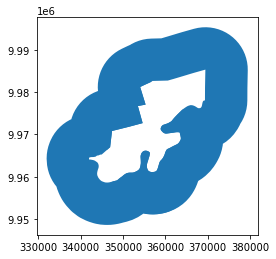

In [16]:
# 4 Create Buffer
buf3km = roi_import_proj.copy()
buf10km = roi_import_proj.copy()

# Create RoI + Buffer 3km
buf3km['geometry'] = buf3km.geometry.buffer(distance = 3000)
# Create RoI + Buffer 10km
buf10km['geometry'] = buf10km.geometry.buffer(distance = 10000)

# create ring buffer through symmetrical difference
#ring_buf3km = buf3km.copy()
#ring_buf3km['geometry'] = buf3km.symmetric_difference(roi_import_proj)
ring_buf3km = buf3km.overlay(roi_import_proj, how ='difference')

#ring_buf10km = buf10km.copy()
#ring_buf10km['geometry'] = buf10km.symmetric_difference(roi_import_proj)
ring_buf10km = buf10km.overlay(roi_import_proj, how ='difference')

#buf3km.plot()
#buf10km.plot()
#roi_import_proj.plot()
#ring_buf3km.plot()
#ring_buf10km.plot()

# convert to feature collection
roi_buffer_3km = geemap.geopandas_to_ee(ring_buf3km, geodesic=False)
roi_buffer_10km = geemap.geopandas_to_ee(ring_buf10km, geodesic=False)

## Data Processing
Data processing contains the reclassification of Hansen tree cover according to the canopy cover threshold and sieveing at the minimum mapping area unit (Ha) to generate Forest Map in 2000 and 2022; Annual and Accumulative Forest Loss 2001-2022 in the Forest Map 2000 and sieving at the minimum mapping area unit (Ha); Primary Forest and sieving at the minimum mapping area unit (Ha)  to generate Forest Map in 2001 and 2022.

In [65]:
# Import Hansen image dataset
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
primaryForests = ee.ImageCollection("UMD/GLAD/PRIMARY_HUMID_TROPICAL_FORESTS/v1").mosaic().selfMask();

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

#### Reproject Hansen dataset to UTM

In [66]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)
primaryForests_proj = primaryForests.reproject(crs = projection, scale = 30)

#### Apply the minimum mapping area unit

In [67]:
# 1. Primary Forest 2001
primaryForestContArea = primaryForests_proj.connectedPixelCount();
# Apply the minimum area on primary forest
primaryForestMinArea = primaryForestContArea.gte(pixels).selfMask();

In [68]:
# 2 Forest Map in 2000 (Non-primary forest 2000)
# 2.1 Define forest area by >= canopy cover
forest_canopy = treeCover_proj.gte(forest_threshold);

# 2.2 Define non-primary forest from pirmary forest dataset
primaryForestUnmask = primaryForestMinArea.unmask();
primaryForestEq0 = primaryForestUnmask.select('Primary_HT_forests').eq(0);

# 2.3 Mask forest canopy cover threshold with nonprimary forest
forestCC = forest_canopy.updateMask(forest_canopy.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(primaryForestEq0);

# 2.4 Apply smoothing
forestContArea = forestCC.connectedPixelCount();
forestMinArea = forestContArea.gte(pixels).selfMask();

In [69]:
# 3 Accumulated Forest loss 2001-2021:

# 3.1 Accumulated Forest Loss in non-primary forest loss
# 3.1.1 Estimate forest loss in forest 2000 >= Canopy cover
maskerforestLoss = lossImage_year_proj.gte(1);
forestLoss = lossImage_proj .updateMask(forestCC.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLoss);
## Create a contiguous area.
contLoss = forestLoss.connectedPixelCount();
minLoss = contLoss.gte(lossPixels).selfMask();

# 3.2 Accumulated Forest Loss 2002-2021 in Primary Forest
# 3.2.1 Estimate forest loss exclusively in primary forest
MaskedPrimaryLoss= lossImage_year_proj.gte(2); ##// loss between 2002-2021
primaryLoss = lossImage_year_proj.updateMask(MaskedPrimaryLoss).updateMask(primaryForestMinArea).updateMask(landmask_proj.eq(1))
# 3.2.2 primary loss filtered by min mapping area
contPrimaryLoss= primaryLoss.connectedPixelCount();
minPrimaryLoss = contPrimaryLoss.gte(lossPixels).selfMask();

In [70]:
# 4 Annual Forest Loss 2001-2021
# 4.1 Non-primary forest
AnnualTreeLoss = lossImage_year_proj.updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1))
## Create a contiguous area.
contAnnualLoss = AnnualTreeLoss.connectedPixelCount();
minAnnualLoss = contAnnualLoss.gte(lossPixels).selfMask();
minAnnualloss_masked = lossImage_year_proj.updateMask(minAnnualLoss)

# 4.2 Primary Forest
annual_PrimaryLoss = lossImage_year_proj.updateMask(primaryForestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(MaskedPrimaryLoss.eq(1))
##** var primaryForestLoss = primaryLoss.updateMask(primaryForestMinArea);
##** Create contiguous area within primary forest loss
contAnnualPrimaryLoss = annual_PrimaryLoss.connectedPixelCount();
minAnnualPrimaryLoss = contAnnualPrimaryLoss.gte(lossPixels).selfMask();
minAnnualPrimaryLoss_masked = annual_PrimaryLoss.updateMask(minAnnualPrimaryLoss)

In [71]:
# 5. Primary Forest 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
PrimaryMinLossUnmask = minPrimaryLoss.unmask();
PrimaryNotLoss = PrimaryMinLossUnmask.select('lossyear').eq(0);
PrimaryForestCover22 = primaryForestMinArea.updateMask(PrimaryNotLoss);

In [72]:
# 6 Forest Map in 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
minLossUnmask = minLoss.unmask();
notLoss = minLossUnmask.select('loss').eq(0);
primaryForestUnmask = primaryForestMinArea.unmask();
notprimaryForest = primaryForestUnmask.select('Primary_HT_forests').eq(0);
forestCover22 = forestMinArea .updateMask(notLoss).updateMask(notprimaryForest);

In [73]:
# clip raster by roi, buffer 3km, buffer 10km to avoid error
# 1. Forest 2000 and 2022
FNF_00_Final = forestMinArea.clip(roi)
FNF_00_Ring_Buffer3km = forestMinArea.clip(roi_buffer_3km)
FNF_00_Ring_Buffer10km = forestMinArea.clip(roi_buffer_10km)

FNF_22_Final = forestCover22.clip(roi)
FNF_22_Ring_Buffer3km = forestCover22.clip(roi_buffer_3km)
FNF_22_Ring_Buffer10km = forestCover22.clip(roi_buffer_10km)

# 2. Primary Forest 2000
PF_00_Final = primaryForestMinArea.clip(roi)
PF_00_Ring_Buffer3km = primaryForestMinArea.clip(roi_buffer_3km)
PF_00_Ring_Buffer10km = primaryForestMinArea.clip(roi_buffer_10km)

PF_22_Final = PrimaryForestCover22.clip(roi)
PF_22_Ring_Buffer3km = PrimaryForestCover22.clip(roi_buffer_3km)
PF_22_Ring_Buffer10km = PrimaryForestCover22.clip(roi_buffer_10km)

# 3. Annual Forest Loss 2001-2022
Annual_FL_01_21_Final = minAnnualloss_masked.clip(roi)
Annual_FL_01_21_Ring_Buffer3km = minAnnualloss_masked.clip(roi_buffer_3km)
Annual_FL_01_21_Ring_Buffer10km = minAnnualloss_masked.clip(roi_buffer_10km)

# 4. Annual Primary Forest Loss 2001-2022
Annual_PFL_01_21_Final = minAnnualPrimaryLoss_masked.clip(roi)
Annual_PFL_01_21_Ring_Buffer3km = minAnnualPrimaryLoss_masked.clip(roi_buffer_3km)
Annual_PFL_01_21_Ring_Buffer10km = minAnnualPrimaryLoss_masked.clip(roi_buffer_10km)

## Interactive Map visualization
Map visualization of Forest/Non-Forest Map in 2000 and 2022; Annual Forest Loss 2001-2022; and Primary Forest in 2000 and 2022. The map also shows the side by side comparison between Forest Map in 2000 and Forest Map in 2022

### Specify parameter for visualisation

In [74]:
# Visualization Parameters
# Forest 2000- Green
vis_treecover = {'palette': ['000000', '00FF00'], 'max': 100};
# Accumulated Forest Loss 2001-2020
vis_loss = {'palette': ['FF0000']};
# Annual forest loss 2001-2020
vis_loss_year = {'palette': ['blue', 'red'], 'min':1, 'max': 21};
vis_prim_loss_year = {'palette': ['blue', 'yellow', 'red'], 'min':2, 'max': 21};
# Forest non forest map
vis_forestnonforest = {'palette': ['#008000']};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_ring_buffer_3km = {'color': '#0000FF', 'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_ring_buffer_10km = {'color': '#FFFF00', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

### Interactive Map

#### Dynamic Map

In [75]:
Map = geemap.Map()

Map.centerObject(roi, 10)
# 1. RoI and buffer
Map.addLayer(roi.style(**vis_roi), {}, "Region of Interest")
Map.addLayer(roi_buffer_3km.style(**vis_ring_buffer_3km), {}, 'buffer 3km', False)
Map.addLayer(roi_buffer_10km.style(**vis_ring_buffer_10km), {}, 'buffer 10km',False)
# 2 Forest in 2000
Map.addLayer(forestMinArea.clip(roi), vis_forestnonforest, "Forest/Non-forest 2000")
#Map.addLayer(forestMinArea, vis_forestnonforest, "Forest/Non-forest 2000")
# Map.addLayer(FNF_00_Ring_Buffer3km, vis_forestnonforest, "Forest/Non-forest 2000 - Buffer 3km", False)
#Map.addLayer(primaryForestMinArea.clip(roi), vis_forestnonforest, 'Primary Forest 2001')
# 3 Forest Loss in 2001 -2021
Map.addLayer(minLoss.clip(roi), vis_loss_year, "Accumulated Forest Loss 2001-2021")
Map.addLayer(minPrimaryLoss.clip(roi), vis_loss_year, "Accumulated Forest Loss in Primary Forest 2001-2021")
Map.addLayer(minAnnualloss_masked.clip(roi), vis_loss_year, "Annual Forest Loss 2001-2021", False)
Map.addLayer(minAnnualPrimaryLoss_masked.clip(roi), vis_loss_year, 'Annual Primary Forest Loss 2001-2021', False)
#Map.addLayer(Annual_PFL_01_21_Ring_Buffer3km, vis_loss_year, 'Annual Primary Forest Loss 2001-2021 - Buffer 3km', False)
#Map.addLayer(Annual_PFL_01_21_Ring_Buffer10km, vis_loss_year, 'Annual Primary Forest Loss 2001-2021 - Buffer 10km', False)
#Map.addLayer(Annual_FL_01_21_Ring_Buffer3km, vis_loss_year, "Annual Forest Loss 2001-2021 - 3km", False)

# 4. Forest in 2022
#Map.addLayer(forestCover22.clip(roi), vis_forestnonforest, 'Forest/Non-forest 2022',False)
#Map.addLayer(PrimaryForestCover22.clip(roi), vis_forestnonforest, 'Primary Forest 2022',False)

# 5. global
#Map.addLayer(minAnnualloss_masked, vis_loss_year, "Global Annual Forest Loss 2001-2021", False)
#Map.addLayer(primaryForestMinArea, vis_forestnonforest, 'global primary forest 2001')
#Map.addLayer(minAnnualPrimaryLoss_masked, vis_loss_year, 'global annual primary forest loss 2001-2022')

Map

Map(center=[-0.25216403524056374, 109.74596494303448], controls=(WidgetControl(options=['position', 'transpare…

#### Split Panel Map

In [19]:
# Split panel map for forest map in 2000 (left) with forest map in 2022 (right)
Map2 = geemap.Map(basemap='HYBRID')
left_map = geemap.ee_tile_layer(forestMinArea.clip(roi), vis_forestnonforest, "Forest/Non-forest 2000")
right_map = geemap.ee_tile_layer(forestCover22.clip(roi), vis_forestnonforest, 'Forest/Non-forest 2022')
Map2.split_map(left_map, right_map)
Map2.addLayer(roi.style(**vis_roi),{},'roi')
Map2.centerObject(roi, 10)
Map2

Map(center=[-0.2548669985220643, 109.71155571991196], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Zonal Statistic
Area estimation in RoI, Buffer 3km and Buffer 10km. The outputs will be exported as excel file in the directory folder output

In [76]:
# output directory
out_dir = os.path.expanduser(output_directory+'/Results')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### 1. Forest Area in 2000 in Rol, Buffer 3km and Buffer 10km

In [33]:
# 1 Region of Interest
FNF00_roi_dir = os.path.join(out_dir, projectname + '_FNF_2000_roi.csv')
geemap.zonal_statistics_by_group(
    FNF_00_Final,
    roi,
    FNF00_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection,
)
# 2 Buffer 3km
FNF00_Buffer3km_dir = os.path.join(out_dir, projectname + '_FNF_2000_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    FNF_00_Ring_Buffer3km,
    roi_buffer_3km,
    FNF00_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
FNF00_Buffer10km_dir = os.path.join(out_dir, projectname + '_FNF_2000_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    FNF_00_Ring_Buffer10km,
    roi_buffer_10km,
    FNF00_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_FNF_2000_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_FNF_2000_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_FNF_2000_RingBuffer10km.csv


### 2. Primary Forest 2000 in Rol, Buffer 3km and Buffer 10km

In [34]:
# 1 Region of Interest
PF_00_roi_dir = os.path.join(out_dir, projectname + '_PrimaryForest_2000_roi.csv')
geemap.zonal_statistics_by_group(
    PF_00_Final,
    roi,
    PF_00_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 2 Buffer 3km
PF_00_Buffer3km_dir = os.path.join(out_dir, projectname + '_PrimaryForest_2000_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    PF_00_Ring_Buffer3km,
    roi_buffer_3km,
    PF_00_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
PF_00_Buffer10km_dir = os.path.join(out_dir, projectname + '_PrimaryForest_2000_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    PF_00_Ring_Buffer10km,
    roi_buffer_10km,
    PF_00_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_PrimaryForest_2000_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_PrimaryForest_2000_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\Kubu Raya\02 Hansen Assessment\Results\Kubu Raya 2 Village_PrimaryForest_2000_RingBuffer10km.csv


### 3. Annual Forest Loss 2001-2021 in Rol, Buffer 3km and Buffer 10km

In [81]:
# 1 Region of Interest
AnnualForestLoss0121_roi_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2001_2021_roi.csv')
geemap.zonal_statistics_by_group(
    Annual_FL_01_21_Final,
    roi,
    AnnualForestLoss0121_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 2 Buffer 3km
AnnualForestLoss0121_Buffer3km_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2001_2021_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    Annual_FL_01_21_Ring_Buffer3km,
    roi_buffer_3km,
    AnnualForestLoss0121_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
AnnualForestLoss0121_Buffer10km_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2001_2021_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    Annual_FL_01_21_Ring_Buffer10km,
    roi_buffer_10km,
    AnnualForestLoss0121_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualForestLoss_2001_2021_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualForestLoss_2001_2021_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualForestLoss_2001_2021_RingBuffer10km.csv


### 4 Annual Primary Forest Loss 2002-2022

In [77]:
# 1 Region of Interest
AnnualPrimaryForestLoss0221_roi_dir = os.path.join(out_dir, projectname + '_AnnualPrimaryForestLoss_2002_2021_roi.csv')
geemap.zonal_statistics_by_group(
    Annual_PFL_01_21_Final,
    roi,
    AnnualPrimaryForestLoss0221_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 2 Buffer 3km
AnnualPrimaryForestLoss0221_Buffer3km_dir = os.path.join(out_dir, projectname + '_AnnualPrimaryForestLoss_2002_2021_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    Annual_PFL_01_21_Ring_Buffer3km,
    roi_buffer_3km,
    AnnualPrimaryForestLoss0221_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
AnnualPrimaryForestLoss0221_Buffer10km_dir = os.path.join(out_dir, projectname + '_AnnualPrimaryForestLoss_2002_2021_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    Annual_PFL_01_21_Ring_Buffer10km,
    roi_buffer_10km,
    AnnualPrimaryForestLoss0221_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualPrimaryForestLoss_2002_2021_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualPrimaryForestLoss_2002_2021_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Feasibility Study\GIS Data\geemap buffer 3km test\Results\test_AnnualPrimaryForestLoss_2002_2021_RingBuffer10km.csv


## Export data
Note: Large size can't be downloaded directly to the directory folder. It has to be exported via google drive

### 1. Forest Map 2000 and 2022 in RoI, Buffer 3Km, Buffer 10Km

In [37]:
# 1. Forest Map 2000
# 1.1. RoI
geemap.ee_export_image_to_drive(
    FNF_00_Final,
    description = projectname + '_Forest_2000_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2000_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 1.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    FNF_00_Ring_Buffer3km,
    description = projectname + '_Forest_2000_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2000_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 1.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    FNF_00_Ring_Buffer10km,
    description = projectname + '_Forest_2000_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2000_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# 2. Forest Map 2022
# 2.1. RoI
geemap.ee_export_image_to_drive(
    FNF_22_Final,
    description = projectname + '_Forest_2022_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 2.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    FNF_22_Ring_Buffer3km,
    description = projectname + '_Forest_2022_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 2.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    FNF_22_Ring_Buffer10km,
    description = projectname + '_Forest_2022_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

### 2. Primary Forest 2000 and 2022 in RoI, Buffer 3Km, Buffer 10Km

In [26]:
# 1. Primary Forest Map 2000
# 1.1. RoI
geemap.ee_export_image_to_drive(
    PF_00_Final,
    description = projectname + '_PrimaryForest_2000_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2000_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 1.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    PF_00_Ring_Buffer3km,
    description = projectname + '_PrimaryForest_2000_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2000_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 1.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    PF_00_Ring_Buffer10km,
    description = projectname + '_PrimaryForest_2000_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2000_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# 2. Primary Forest Map 2022
# 2.1. RoI
geemap.ee_export_image_to_drive(
    PF_22_Final,
    description = projectname + '_PrimaryForest_2022_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 2.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    PF_22_Ring_Buffer3km,
    description = projectname + '_PrimaryForest_2022_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2022_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 2.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    PF_22_Ring_Buffer10km,
    description = projectname + '_PrimaryForest_2022_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForest_2022_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

### 3. Annual Forest Loss 2001-2022 and Primary Forest Loss 2002-2022

In [79]:
# 1. Forest Loss 2001-2022
# 1.1. RoI
geemap.ee_export_image_to_drive(
    Annual_FL_01_21_Final,
    description = projectname + '_ForestLoss_2001_2022_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2001_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 1.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    Annual_FL_01_21_Ring_Buffer3km,
    description = projectname + '_ForestLoss_2001_2022_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2001_2022_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 1.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    Annual_FL_01_21_Ring_Buffer10km,
    description = projectname + '_ForestLoss_2001_2022_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2001_2022_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)


# 2. Annual Primary Forest Loss 2002-2022
# 2.1. RoI
geemap.ee_export_image_to_drive(
    Annual_PFL_01_21_Final,
    description = projectname + '_PrimaryForestLoss_2001_2022_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForestLoss_2001_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 2.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    Annual_PFL_01_21_Ring_Buffer3km,
    description = projectname + '_PrimaryForestLoss_2001_2022_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForestLoss_2001_2022_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 2.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    Annual_PFL_01_21_Ring_Buffer10km,
    description = projectname + '_PrimaryForestLoss_2001_2022_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_PrimaryForestLoss_2001_2022_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# Rapid Assessment - Hansen Data Visualization

## Data Visualization

### Annual Forest Loss 2001-2021

#### Data Preprocessing

In [82]:
# 1. Annual ForestLoss in Non-primary Forest 2001-2021
# 1.1 RoI
annual_forestloss_table = pd.read_csv(AnnualForestLoss0121_roi_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_table_transpose = annual_forestloss_table.T # or df1.transpose()
annual_forestloss_table_transpose.columns = annual_forestloss_table_transpose.loc[roi_column_name]
annual_forestloss_table_transpose = annual_forestloss_table_transpose.loc[annual_forestloss_table_transpose.index.str.contains('Class_')]
annual_forestloss_table_transpose = annual_forestloss_table_transpose.reset_index(level=0)
annual_forestloss_table_transpose = annual_forestloss_table_transpose[annual_forestloss_table_transpose['index'] != 'Class_sum']
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_table_transpose = annual_forestloss_table_transpose.sort_values(by=['Year'])
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['Year'] + 2000
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['Year'].astype(str)
annual_forestloss_table_transpose['Data'] = 'Deforestation in Non-Primary Forest 2001-2021'
annual_forestloss_table_transpose['Region'] ='RoI'
#annual_forestloss_table_transpose

# 1.2 Buffer 3km
annual_forestloss_3km_table = pd.read_csv(AnnualForestLoss0121_Buffer3km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table.T # or df1.transpose()
annual_forestloss_3km_table_transpose.columns = annual_forestloss_3km_table_transpose.loc[roi_column_name]
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.loc[annual_forestloss_3km_table_transpose.index.str.contains('Class_')]
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.reset_index(level=0)
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose[annual_forestloss_3km_table_transpose['index'] != 'Class_sum']
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.sort_values(by=['Year'])
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['Year'] + 2000
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['Year'].astype(str)
annual_forestloss_3km_table_transpose['Data'] = 'Deforestation in Non-Primary Forest 2001-2021'
annual_forestloss_3km_table_transpose['Region'] ='3km Buffer'
#annual_forestloss_3km_table_transpose

# 1.3 Buffer 10km
annual_forestloss_10km_table = pd.read_csv(AnnualForestLoss0121_Buffer10km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table.T # or df1.transpose()
annual_forestloss_10km_table_transpose.columns = annual_forestloss_10km_table_transpose.loc[roi_column_name]
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.loc[annual_forestloss_10km_table_transpose.index.str.contains('Class_')]
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.reset_index(level=0)
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose[annual_forestloss_10km_table_transpose['index'] != 'Class_sum']
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.sort_values(by=['Year'])
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['Year'] + 2000
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['Year'].astype(str)
annual_forestloss_10km_table_transpose['Data'] = 'Deforestation in Non-Primary Forest 2001-2021'
annual_forestloss_10km_table_transpose['Region'] ='10km Buffer'
#annual_forestloss_10km_table_transpose

In [83]:
# 2. Annual ForestLoss in Primary Forest 2001-2021
# 2.1 RoI
annual_Primaryforestloss_table = pd.read_csv(AnnualPrimaryForestLoss0221_roi_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_Primaryforestloss_table_transpose = annual_Primaryforestloss_table.T # or df1.transpose()
annual_Primaryforestloss_table_transpose.columns = annual_Primaryforestloss_table_transpose.loc[roi_column_name]
annual_Primaryforestloss_table_transpose = annual_Primaryforestloss_table_transpose.loc[annual_Primaryforestloss_table_transpose.index.str.contains('Class_')]
annual_Primaryforestloss_table_transpose = annual_Primaryforestloss_table_transpose.reset_index(level=0)
annual_Primaryforestloss_table_transpose = annual_Primaryforestloss_table_transpose[annual_Primaryforestloss_table_transpose['index'] != 'Class_sum']
annual_Primaryforestloss_table_transpose['Year'] = annual_Primaryforestloss_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_Primaryforestloss_table_transpose = annual_Primaryforestloss_table_transpose.sort_values(by=['Year'])
annual_Primaryforestloss_table_transpose['Year'] = annual_Primaryforestloss_table_transpose['Year'] + 2000
annual_Primaryforestloss_table_transpose['Year'] = annual_Primaryforestloss_table_transpose['Year'].astype(str)
annual_Primaryforestloss_table_transpose['Data'] = 'Deforestation in Primary Forest 2002-2021'
annual_Primaryforestloss_table_transpose['Region'] ='RoI'
#annual_Primaryforestloss_table_transpose

# 2.2 Buffer 3km
annual_Primaryforestloss_3km_table = pd.read_csv(AnnualPrimaryForestLoss0221_Buffer3km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_Primaryforestloss_3km_table_transpose = annual_Primaryforestloss_3km_table.T # or df1.transpose()
annual_Primaryforestloss_3km_table_transpose.columns = annual_Primaryforestloss_3km_table_transpose.loc[roi_column_name]
annual_Primaryforestloss_3km_table_transpose = annual_Primaryforestloss_3km_table_transpose.loc[annual_Primaryforestloss_3km_table_transpose.index.str.contains('Class_')]
annual_Primaryforestloss_3km_table_transpose = annual_Primaryforestloss_3km_table_transpose.reset_index(level=0)
annual_Primaryforestloss_3km_table_transpose = annual_Primaryforestloss_3km_table_transpose[annual_Primaryforestloss_3km_table_transpose['index'] != 'Class_sum']
annual_Primaryforestloss_3km_table_transpose['Year'] = annual_Primaryforestloss_3km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_Primaryforestloss_3km_table_transpose = annual_Primaryforestloss_3km_table_transpose.sort_values(by=['Year'])
annual_Primaryforestloss_3km_table_transpose['Year'] = annual_Primaryforestloss_3km_table_transpose['Year'] + 2000
annual_Primaryforestloss_3km_table_transpose['Year'] = annual_Primaryforestloss_3km_table_transpose['Year'].astype(str)
annual_Primaryforestloss_3km_table_transpose['Data'] = 'Deforestation in Primary Forest 2002-2021'
annual_Primaryforestloss_3km_table_transpose['Region'] ='3km Buffer'
#annual_Primaryforestloss_3km_table_transpose

# 2.3 Buffer 10km
annual_Primaryforestloss_10km_table = pd.read_csv(AnnualPrimaryForestLoss0221_Buffer10km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_Primaryforestloss_10km_table_transpose = annual_Primaryforestloss_10km_table.T # or df1.transpose()
annual_Primaryforestloss_10km_table_transpose.columns = annual_Primaryforestloss_10km_table_transpose.loc[roi_column_name]
annual_Primaryforestloss_10km_table_transpose = annual_Primaryforestloss_10km_table_transpose.loc[annual_Primaryforestloss_10km_table_transpose.index.str.contains('Class_')]
annual_Primaryforestloss_10km_table_transpose = annual_Primaryforestloss_10km_table_transpose.reset_index(level=0)
annual_Primaryforestloss_10km_table_transpose = annual_Primaryforestloss_10km_table_transpose[annual_Primaryforestloss_10km_table_transpose['index'] != 'Class_sum']
annual_Primaryforestloss_10km_table_transpose['Year'] = annual_Primaryforestloss_10km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_Primaryforestloss_10km_table_transpose = annual_Primaryforestloss_10km_table_transpose.sort_values(by=['Year'])
annual_Primaryforestloss_10km_table_transpose['Year'] = annual_Primaryforestloss_10km_table_transpose['Year'] + 2000
annual_Primaryforestloss_10km_table_transpose['Year'] = annual_Primaryforestloss_10km_table_transpose['Year'].astype(str)
annual_Primaryforestloss_10km_table_transpose['Data'] = 'Deforestation in Primary Forest 2002-2021'
annual_Primaryforestloss_10km_table_transpose['Region'] ='10km Buffer'
#annual_Primaryforestloss_10km_table_transpose

In [84]:
Merge_Loss_Prim_NonPrim = pd.concat([annual_forestloss_table_transpose, annual_Primaryforestloss_table_transpose], ignore_index=True)
Merge_Loss_RoI_3km_10km = pd.concat([annual_forestloss_table_transpose, annual_forestloss_3km_table_transpose, annual_forestloss_10km_table_transpose], ignore_index=True)
Merge_PrimLoss_RoI_3km_10km = pd.concat([annual_Primaryforestloss_table_transpose, annual_Primaryforestloss_3km_table_transpose, annual_Primaryforestloss_10km_table_transpose], ignore_index=True)
#Mege_Loss_RoI_3km_10km

#### Comparative Graph Annual Forest Loss in Non-primary and Primary Forest

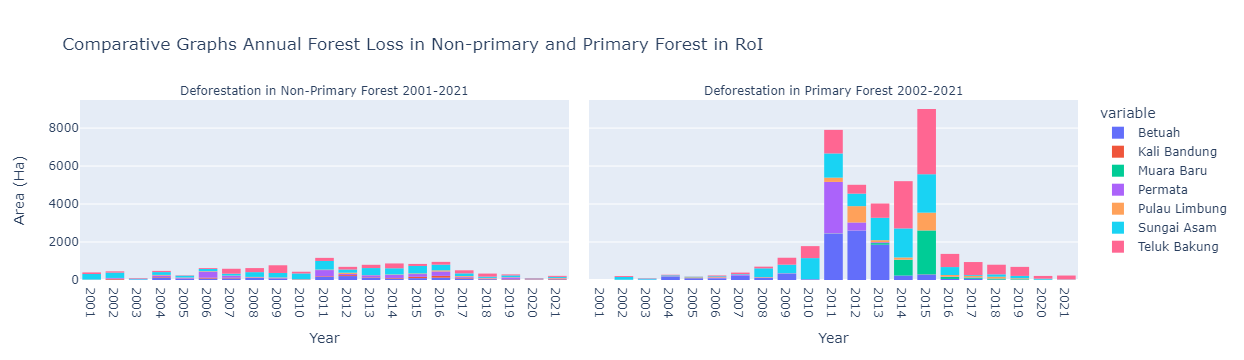

In [85]:
# Helper for specifying y value
y_axis_name = list(Merge_Loss_Prim_NonPrim.columns.values)
y_axis_name.remove('index')
y_axis_name.remove('Year')
y_axis_name.remove('Region')

# Create Histogram
fig = px.histogram(Merge_Loss_Prim_NonPrim, x = 'Year' , y = y_axis_name,   title = "Comparative Graphs Annual Forest Loss in Non-primary and Primary Forest in RoI", facet_col= 'Data').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Comparative Graph of Forest Loss in RoI, Buffer 3km and Buffer 10km

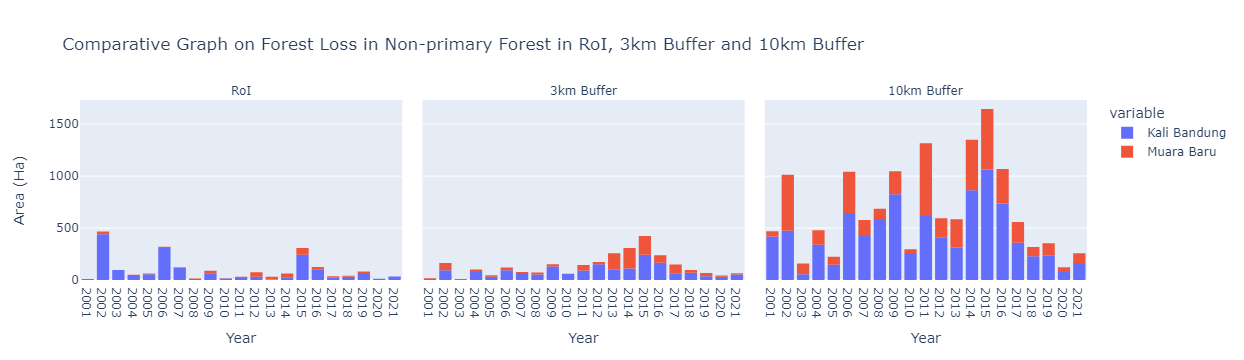

In [42]:
# Helper for specifying y value
y_axis_name_Loss_roi_buffer = list(Merge_Loss_RoI_3km_10km.columns.values)
y_axis_name_Loss_roi_buffer.remove('index')
y_axis_name_Loss_roi_buffer.remove('Year')
y_axis_name_Loss_roi_buffer.remove('Data')


# Create Histogram
fig_roi_buffer = px.histogram(Merge_Loss_RoI_3km_10km, x = 'Year' , y = y_axis_name_Loss_roi_buffer,   title = "Comparative Graph on Forest Loss in Non-primary Forest in RoI, 3km Buffer and 10km Buffer", facet_col= 'Region').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig_roi_buffer.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Comparative Graph of Primary Forest Loss in RoI, Buffer 3km and Buffer 10km

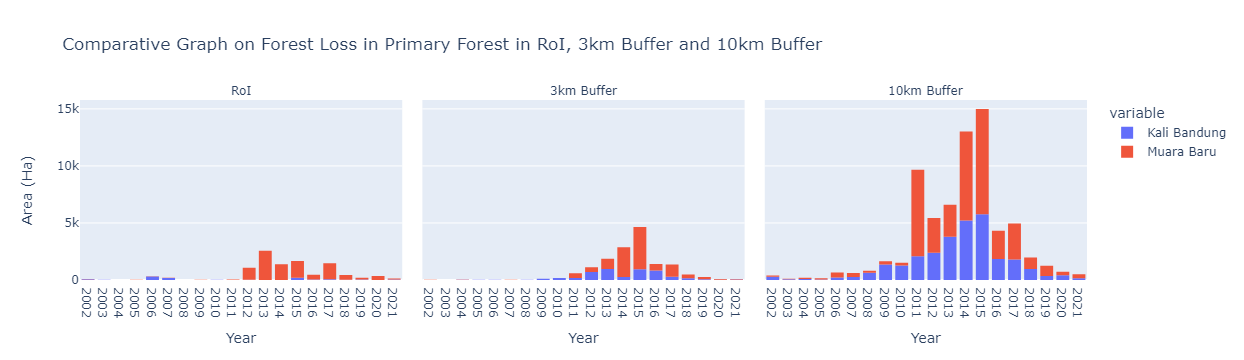

In [33]:
# Helper for specifying y value
y_axis_name_PrimLoss_roi_buffer = list(Merge_PrimLoss_RoI_3km_10km.columns.values)
y_axis_name_PrimLoss_roi_buffer.remove('index')
y_axis_name_PrimLoss_roi_buffer.remove('Year')
y_axis_name_PrimLoss_roi_buffer.remove('Data')

# Create Histogram
fig_roi_buffer = px.histogram(Merge_PrimLoss_RoI_3km_10km, x = 'Year' , y = y_axis_name_PrimLoss_roi_buffer,   title = "Comparative Graph on Forest Loss in Primary Forest in RoI, 3km Buffer and 10km Buffer", facet_col= 'Region').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig_roi_buffer.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

## Geospatial Visualisation

### Import Raster Data

In [7]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [8]:
# Import Raster Data
primaryforest00_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_2000_roi.tif').replace(os.sep, '/'))
AnnualprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForestLoss_2001_2022_roi.tif').replace(os.sep, '/'))

Nonprimaryforest00_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2000_roi.tif').replace(os.sep, '/'))
AnnualNonprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_2001_2022_roi.tif').replace(os.sep, '/'))

### Data Preparation

#### Primary Forest and Primary Forest Loss

In [12]:
# Create parameters from converting numpy to raster
upperleft_bound = primaryforest00_geotiff.transform * (0, 0)
pixel_size = primaryforest00_geotiff.transform[0]

# overlay priimary + primary forest loss
primforest_loss_overlay = primaryforest00_geotiff.read(1) * 100 + AnnualprimaryforestLoss_geotiff.read(1)

new_transform = rasterio.transform.from_origin(upperleft_bound[0],upperleft_bound[1],pixel_size,pixel_size)
new_dataset = rasterio.open(
    os.path.join(raster_directory, projectname + '_PrimaryForest_ForestLoss_roi.tif').replace(os.sep, '/'), "w", 
    driver = "GTiff",
    height = primforest_loss_overlay.shape[0],
    width = primforest_loss_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = primforest_loss_overlay.dtype,
    crs = projection,
    transform = new_transform
)
new_dataset.write(primforest_loss_overlay, 1)
new_dataset.close()

#### Non-primary and Non-primary Forest Loss

In [13]:
# Create parameters from converting numpy to raster
upperleft_bound_nf = Nonprimaryforest00_geotiff.transform * (0, 0)
pixel_size_nf = Nonprimaryforest00_geotiff.transform[0]

# overlay priimary + primary forest loss
Nonprimforest_loss_overlay = Nonprimaryforest00_geotiff.read(1) * 100 + AnnualNonprimaryforestLoss_geotiff.read(1)

new_transform_nf = rasterio.transform.from_origin(upperleft_bound_nf[0],upperleft_bound_nf[1],pixel_size_nf,pixel_size_nf)
new_dataset_nf = rasterio.open(
    os.path.join(raster_directory, projectname + '_NonPrimaryForest_ForestLoss_roi.tif').replace(os.sep, '/'), "w", 
    driver = "GTiff",
    height = Nonprimforest_loss_overlay.shape[0],
    width = Nonprimforest_loss_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = Nonprimforest_loss_overlay.dtype,
    crs = projection,
    transform = new_transform_nf
)
new_dataset_nf.write(Nonprimforest_loss_overlay, 1)
new_dataset_nf.close()

### Map

#### Primary and Primary Forest Loss Map 

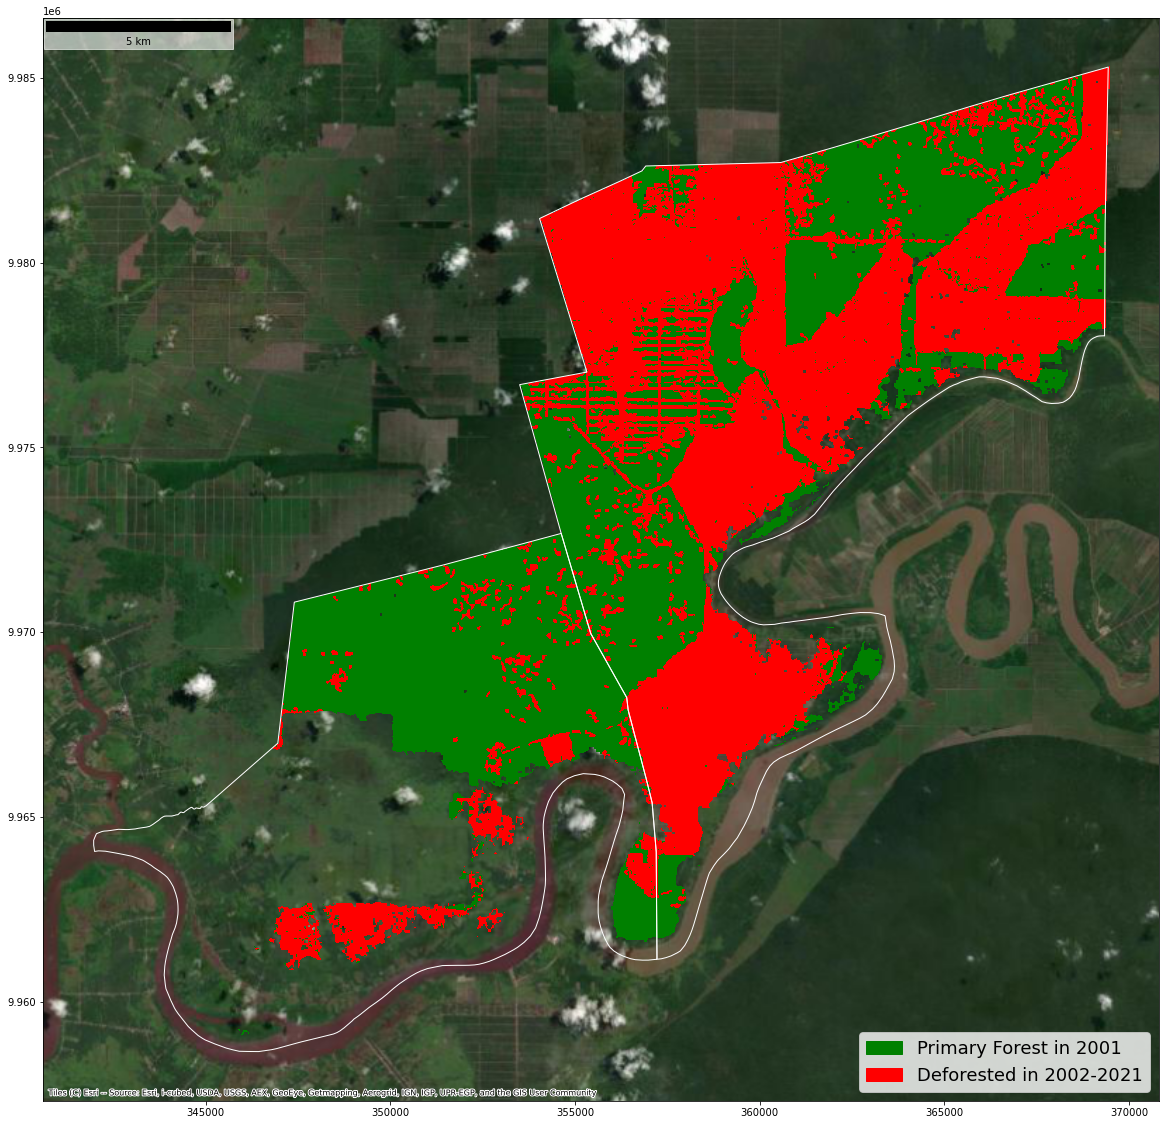

In [19]:
#import overlay raster
Annualprimaryforest_Loss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_ForestLoss_roi.tif').replace(os.sep, '/'))

colors_AnnualprimForestLoss = ['white','green','red']
cmap_AnnualprimForestLoss = ListedColormap(colors_AnnualprimForestLoss)
norm_AnnualprimForestLoss = colors.BoundaryNorm([0,100, 102, 121], 4)

fig, ax = plt.subplots(figsize=(20,20))
legend_labels = {"green": "Primary Forest in 2001",
                 "red" : "Deforested in 2002-2021"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches,facecolor="white", prop={'size': 18}, loc='lower right')
ax.add_artist(ScaleBar(1, box_alpha=0.6, location = 'upper left'))
ax = roi_import_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax)
ax = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_import_proj.crs.to_string(), ax = ax )
ax = rasterio.plot.show(Annualprimaryforest_Loss_geotiff, ax=ax, cmap = cmap_AnnualprimForestLoss, norm = norm_AnnualprimForestLoss)

#### Non-primary Forest and non-primary Forest Loss Map

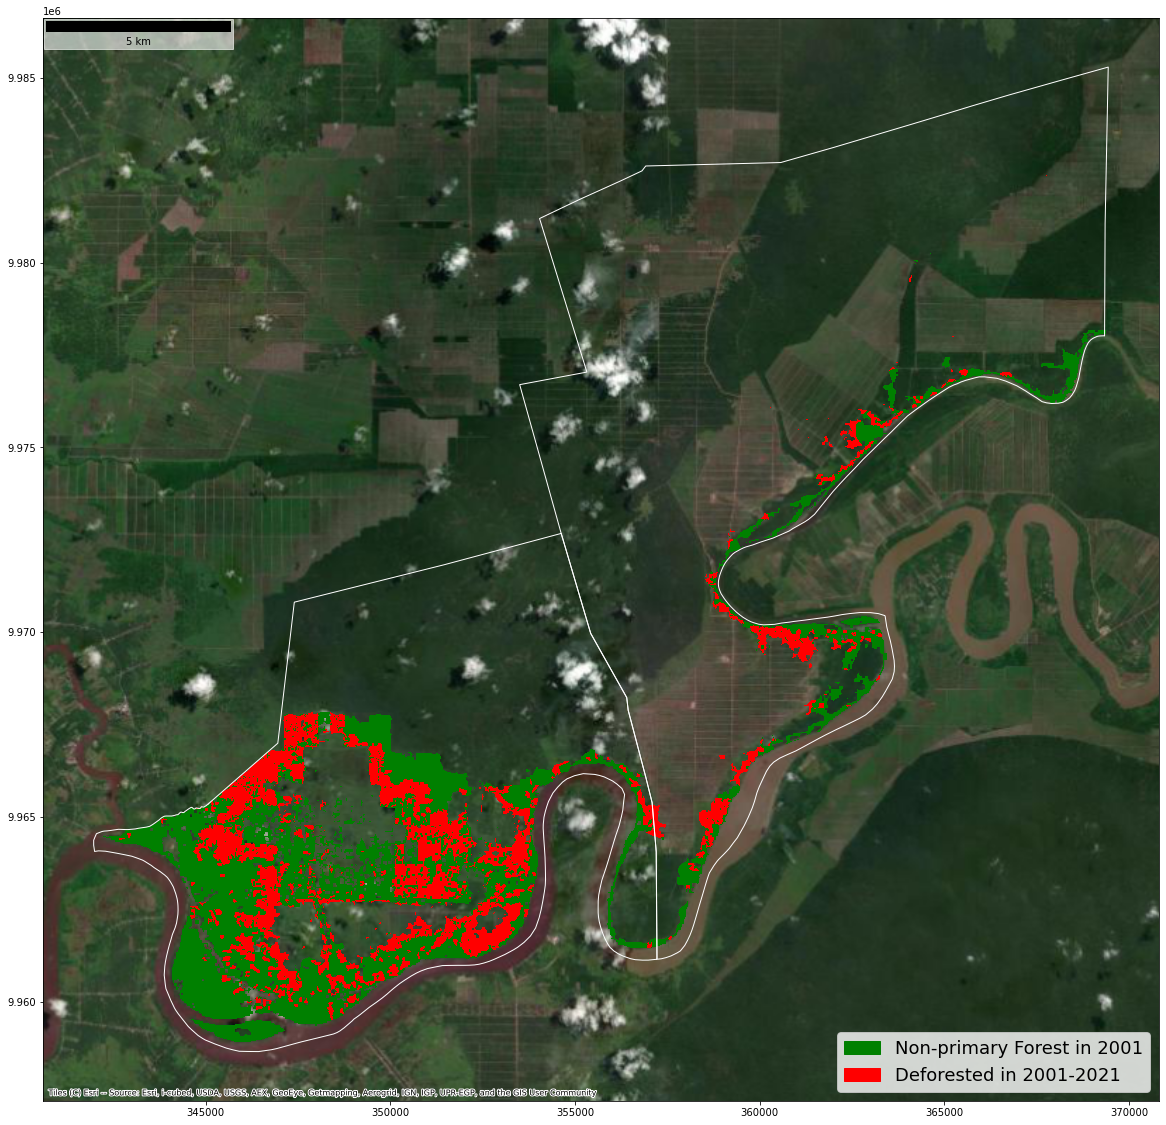

In [20]:
#import overlay raster
Annualnonprimaryforest_Loss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_NonPrimaryForest_ForestLoss_roi.tif').replace(os.sep, '/'))

colors_AnnualNonprimForestLoss = ['white','green','red']
cmap_AnnualNonprimForestLoss = ListedColormap(colors_AnnualNonprimForestLoss)
norm_AnnualNonprimForestLoss = colors.BoundaryNorm([0,100, 102, 121], 4)

fig1, ax1 = plt.subplots(figsize = (20,20))
legend_labels1 = {"green": "Non-primary Forest in 2001",
                 "red" : "Deforested in 2001-2021"}
patches1 = [Patch(color=color, label=label)
           for color, label in legend_labels1.items()]
ax1.legend(handles=patches1,facecolor="white", prop={'size': 18}, loc='lower right')
ax1.add_artist(ScaleBar(1, box_alpha=0.6, location = 'upper left'))
ax1 = roi_import_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax1)
ax1 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_import_proj.crs.to_string(), ax = ax1 )
ax1 = rasterio.plot.show(Annualnonprimaryforest_Loss_geotiff, ax=ax1, cmap = cmap_AnnualprimForestLoss, norm = norm_AnnualprimForestLoss)